<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_Georges_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIDC GDRO: Looking at Clustered Subgroups

Thomas Zeng

## Notebook Setup

Setup autoreload extension

In [1]:
%load_ext autoreload
%autoreload 2

Clone repo (if on colab)

In [2]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 4126, done.
remote: Counting objects: 100% (698/698), done.
remote: Compressing objects: 100% (326/326), done.
remote: Total 4126 (delta 397), reused 660 (delta 371), pack-reused 3428
Receiving objects: 100% (4126/4126), 104.54 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (3545/3545), done.
Checking out files: 100% (5419/5419), done.
/content/LIDC_GDRO


In [ ]:
# !git pull

import necessary libraries

In [3]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 24.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=dfc48ca99c7c514b259f0b46f1d05bb39ff791e59fd55adbf4732a79192bb148
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=1712eed25d8283f40ed78f6ca35a8a4df106c92d80e303c5ab16765bf4cf44e4
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [61]:
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import SubclassedDataset
from models import TransferModel18
from train_eval import train, evaluate, train_epochs
from torch.optim.lr_scheduler import ReduceLROnPlateau
from loss import ERMLoss, GDROLoss 
import os
# import torchvision
from torchvision import transforms
import torch
from utils.image_data_utils import images_to_df, get_features, show_scatter

from umap import UMAP
from matplotlib import pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Get available Device

In [5]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


## ERM Model: Training ERM model to extract CNN features

### ERM Modeling

Just for visulalization, the csv where we get the train, cv, test splits and subgroups come from below csv. 

In [6]:
df_splits = pd.read_csv('./data/train_test_splits/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spic_groups,malignancy,malignancy_b,split
0,1,2,3,1,0
1,2,3,3,1,0
2,3,2,3,1,1
3,4,2,2,1,0
4,5,2,2,1,2


First we get all image in a dataframe

In [137]:
images_df.head()

,noduleID,malignancy,image
0,1,tensor(5),"[[[tensor(0.5412), tensor(0.3216), tensor(0.14..."
1,2,tensor(5),"[[[tensor(0.0392), tensor(0.0392), tensor(0.03..."
2,3,tensor(5),"[[[tensor(0.0353), tensor(0.0392), tensor(0.03..."
3,4,tensor(4),"[[[tensor(0.5294), tensor(0.5294), tensor(0.52..."
4,5,tensor(4),"[[[tensor(0.5608), tensor(0.5451), tensor(0.54..."


First we load in the training data

In [173]:
train_data, cv_data, test_data = get_features(images=True, features=images_df, device=DEVICE, subclass='malignancy')

#datasets
tr = SubclassedDataset(*train_data)
cv = SubclassedDataset(*cv_data)
tst = SubclassedDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/content/LIDC_GDRO/utils/image_data_utils.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['clusters'] = df_splits[subclass]
/content/LIDC_GDRO/utils/image_data_utils.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [178]:
train_data[0].shape

torch.Size([5200, 3, 71, 71])

Next we initialize the model!

In [179]:
model = TransferModel18(device=DEVICE, pretrained=True, freeze=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we train the model

In [180]:
epochs = 15
loss_fn = ERMLoss(model, torch.nn.CrossEntropyLoss())
train_epochs(epochs, tr_loader, tst_loader, model, loss_fn, optimizer, verbose=True, num_subclasses=4)

Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15


In [181]:
evaluate(tst_loader,model, 4, verbose=True)

Accuracy: 0.5813953488372093 
Accuracy over subgroups: [0.86363636 0.75409836 0.18461538 0.29166667] 
Worst Group Accuracy: 0.18461538461538463


(0.5813953488372093,
 0.8636363636363636,
 0.7540983606557377,
 0.18461538461538463,
 0.2916666666666667)

### Feature Extraction

We first save model weights (for reproducibility)

In [ ]:
 torch.save(model.state_dict(), './data/erm_cluster_weights.pt')

Next we add hooks to let us get activations

In [159]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))

We re get the data, but in its entirety with the noduleID

In [160]:
noduleID, data = images_df['noduleID'], torch.stack(list(images_df['image'])).to(DEVICE)

Now we extract features

In [161]:
model(data)
img_features = activation['avgpool'].squeeze()

We collect all the features in a dataframe

In [162]:
cols = []
for idx,id in enumerate(noduleID):
  cols.append([id] + img_features[idx].cpu().numpy().tolist())
df_features_all = pd.DataFrame(cols).rename({0:'noduleID'}, axis=1)
df_features_all.sort_values('noduleID', inplace=True)
df_features_all.reset_index(drop=True, inplace=True)
df_features_all.head()

,noduleID,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,1,1.051813,0.361766,0.082587,0.000000,0.673648,0.434625,0.001245,0.501549,0.185982,...,0.679002,0.126983,0.312371,0.109113,0.727777,0.145028,0.000000,0.258167,1.390953,0.000000
1,2,0.000000,0.559720,0.090982,0.945484,2.115624,0.000000,0.754383,3.194212,0.279615,...,1.115240,0.367821,0.000000,1.106771,1.070549,0.855607,1.609775,1.118934,1.698969,1.933009
2,3,1.846598,1.957506,0.656857,0.993636,0.424603,1.516118,0.741787,0.879153,0.473401,...,0.000000,1.076152,0.225203,0.000000,0.471767,0.055196,1.271514,0.222343,0.178911,0.000000
3,4,2.144681,3.535214,2.146254,0.209434,1.801755,2.495296,0.004590,2.424413,0.834550,...,0.229190,1.808777,2.669962,1.742100,1.427794,0.000000,1.339440,0.000000,0.497846,1.719669
4,5,0.399204,1.271677,0.333945,1.966068,0.785228,0.629306,0.000000,0.000000,0.000000,...,0.219050,0.036821,0.102369,0.541048,0.057741,0.126177,0.082303,0.014729,0.000000,1.632786


We again save the data for reproducibility

In [163]:
df_features_all.to_csv('./data/erm_cluster_cnn_features.csv')

In [164]:
df_features = df_features_all[df_features_all['noduleID'].isin(df_splits['noduleID'])]
df_features.sort_values('noduleID', inplace=True)
df_features.reset_index(drop=True, inplace=True)

df_features['split'] = df_splits['split']
df_features['malignancy'] = df_splits['malignancy']

df_features.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

,noduleID,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,512,split,malignancy
0,1,1.051813,0.361766,0.082587,0.000000,0.673648,0.434625,0.001245,0.501549,0.185982,...,0.312371,0.109113,0.727777,0.145028,0.000000,0.258167,1.390953,0.000000,0,3
1,2,0.000000,0.559720,0.090982,0.945484,2.115624,0.000000,0.754383,3.194212,0.279615,...,0.000000,1.106771,1.070549,0.855607,1.609775,1.118934,1.698969,1.933009,0,3
2,3,1.846598,1.957506,0.656857,0.993636,0.424603,1.516118,0.741787,0.879153,0.473401,...,0.225203,0.000000,0.471767,0.055196,1.271514,0.222343,0.178911,0.000000,1,3
3,4,2.144681,3.535214,2.146254,0.209434,1.801755,2.495296,0.004590,2.424413,0.834550,...,2.669962,1.742100,1.427794,0.000000,1.339440,0.000000,0.497846,1.719669,0,2
4,5,0.399204,1.271677,0.333945,1.966068,0.785228,0.629306,0.000000,0.000000,0.000000,...,0.102369,0.541048,0.057741,0.126177,0.082303,0.014729,0.000000,1.632786,2,2


## Feature Reduce and Cluster

### Feature Reduce

First we split df into two by the splits

In [165]:
df_features_train = df_features[df_features['split'] == 0]
df_features_cv_test = df_features[df_features['split'] != 0]

Next we get the features in an array

In [166]:
train_features = df_features_train.drop(['noduleID', 'split', 'malignancy'], axis=1).values
cv_test_features = df_features_cv_test.drop(['noduleID', 'split', 'malignancy'], axis=1).values

Following the George paper, we use UMAP to dimensionaly reduce our data

In [167]:
reducer = UMAP(random_state=8)
reducer.fit(train_features)

UMAP(random_state=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [168]:
train_embeds = reducer.transform(train_features)

Now we visualize the reduction on train dataset

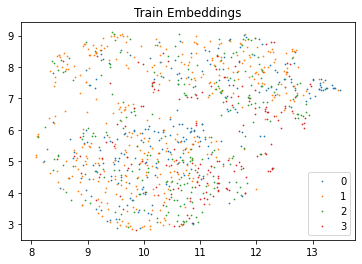

In [169]:
show_scatter(train_embeds[:, 0], train_embeds[:, 1],df_features_train['malignancy'],'Train Embeddings', 0.5)



We also do same visualization on cv and test

In [134]:
cv_test_embeds = reducer.transform(cv_test_features)

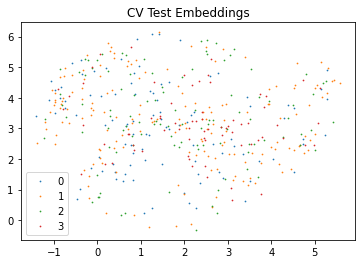

In [135]:
show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],df_features_cv_test['malignancy'],'CV Test Embeddings', 0.5)


We now save the reduce

In [ ]:
f_reducer = './cnn_umap_reducer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))




Note to lode from above file, we can call
```python
reducer = pickle.load((open(f_reducer, 'rb'))) 
```

### Feature Cluster

Now we cluster the training embeddings using Gaussian Mixture

We first visualize the silhouette score

(we only cluster on malignant since that is what we want)

In [ ]:
train_embeds_malig = reducer.transform(train_features[df_features_train['malignancy_b'] == 1])

Text(0, 0.5, 'Silhouette Coefficients')

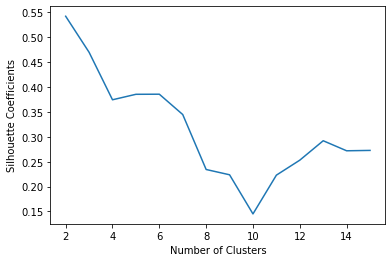

In [ ]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  gmm = GaussianMixture(n_components=cluster, random_state=61).fit(train_embeds_malig)
  labels = gmm.predict(train_embeds_malig)
  
  silhouette_avg = silhouette_score(train_embeds_malig, labels)
  silhouette_coefficients.append(silhouette_avg)

plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

We note from above, the best number of subclasses is 2.

In [ ]:
clusterer = GaussianMixture(n_components=2, random_state=61).fit(train_embeds_malig)

We now visualize the clusters ont train

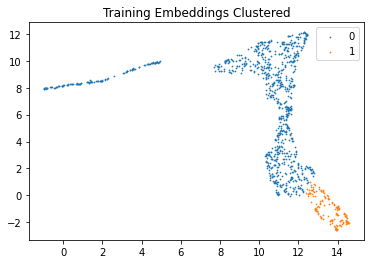

In [ ]:
train_labels = clusterer.predict(train_embeds)

show_scatter(train_embeds[:, 0], train_embeds[:, 1],train_labels,'Training Embeddings Clustered', 0.5)

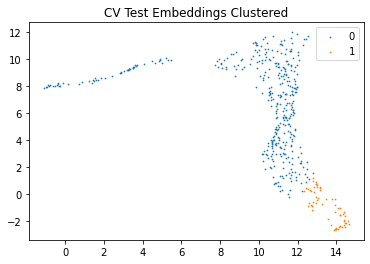

In [ ]:
cv_test_labels = clusterer.predict(cv_test_embeds)

show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],cv_test_labels,'CV Test Embeddings Clustered', 0.5)

Now we save the clusterer

In [ ]:
f_clusterer = './cnn_umap_clusterer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))

### Save the labels

Now that we have the labels, we want to save them to csv we so we can train gDRO on them

In [ ]:
df_features_train['cluster'] = train_labels
df_features_cv_test['cluster'] = cv_test_labels

df_clusters = pd.concat([df_features_train, df_features_cv_test])[['noduleID', 'cluster']]
df_clusters.sort_values('noduleID', inplace=True)
df_clusters.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,noduleID,cluster
0,1,1
1,2,0
2,3,1
3,4,0
4,5,0


We can add these lables to the df_splits dataframe

In [ ]:
df_splits['cluster'] = [ 0 if m % 2 == 0 else 1 + c for m,c in zip(df_splits['malignancy_b'], df_clusters['cluster'])]

In [ ]:
df_splits['cluster']

0       2
1       1
2       2
3       1
4       1
       ..
1483    1
1484    0
1485    0
1486    1
1487    0
Name: cluster, Length: 1488, dtype: int64

Now we save the csv

In [ ]:
df_splits.to_csv('./data/LIDC_data_split_with_cluster(temp).csv')

## Train ERM and gDRO on new models

We again get our dataloaders (but with the new sublables)

In [ ]:
df_splits = pd.read_csv('./data/LIDC_data_split_with_cluster(temp).csv', index_col=0)
df_splits.head()

,noduleID,spic_groups,malignancy,malignancy_b,split,cluster
0,1,2,3,1,0,2
1,2,3,3,1,0,1
2,3,2,3,1,1,2
3,4,2,2,1,0,1
4,5,2,2,1,2,1


In [ ]:
train_data_c, cv_data_c, test_data_c = get_images(split=True, sublabels='cluster', binary=True, device=DEVICE)

#datasets
tr_c = SubclassedDataset(*train_data_c)
cv_c = SubclassedDataset(*cv_data_c)
tst_c = SubclassedDataset(*test_data_c)

#dataloaders
tr_loader_c = InfiniteDataLoader(tr_c, batch_size=128)
cv_loader_c = InfiniteDataLoader(cv_c, len(cv_c))
tst_loader_c = InfiniteDataLoader(tst_c, len(tst_c))

### ERM

In [ ]:
model_ERM = TransferModel18(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
epochs = 15
loss_fn = ERMLoss(model_ERM, torch.nn.CrossEntropyLoss())
optimizer = torch.optim.Adam(model_ERM.parameters(), lr=0.0005, weight_decay=0.005)
train_epochs(epochs, tr_loader_c, cv_loader_c, model_ERM, loss_fn, optimizer, scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True), verbose=True, num_subclasses=3)

Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15


In [ ]:
evaluate(tst_loader_c,model_ERM, 3)

(0.8737541528239202, 0.8895027624309392, 1.0, 0.7831325301204819)

### GDRO

In [ ]:
model_gDRO = TransferModel18(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
epochs = 15
loss_fn = GDROLoss(model_gDRO, torch.nn.CrossEntropyLoss(), 0.01, 3)
optimizer = torch.optim.Adam(model_gDRO.parameters(), lr=0.0005, weight_decay=0.005)
train_epochs(epochs, tr_loader_c, tst_loader_c, model_gDRO, loss_fn, optimizer, scheduler=ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True), verbose=True, num_subclasses=3)

Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-06.
Epoch 15 / 15


In [ ]:
evaluate(tst_loader_c,model_gDRO, 3)

(0.8637873754152824, 0.8895027624309392, 1.0, 0.7469879518072289)